In [24]:
import sys
!{sys.executable} -m pip install matplotlib xgboost shap imbalanced-learn lightgbm catboost 



/Users/mariam/.zshenv:export:2: not valid in this context: Fusion.app/Contents/Public:/usr/local/share/dotnet:~/.dotnet/tools:/Library/Apple/usr/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/local/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/appleinternal/bin:/usr/local/mysql/bin
  Using cached plotly-6.2.0-py3-none-any.whl.metadata (8.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.8/27.8 MB 10.7 MB/s eta 0:00:00a 0:00:01
Using cached plotly-6.2.0-py3-none-any.whl (9.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [catboost]3/4 [catboost]


# Étape 1 : Optimisation du modèle IA (C16)

Cette partie correspond à l’analyse et à l’optimisation du modèle IA pour le scoring d’éligibilité au prêt. Plusieurs modèles seront testés, évalués avec des métriques adaptées (ROC AUC, F1-score), et interprétés avec SHAP.

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score, classification_report
import shap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [15]:
# 1. Charger les données
df = pd.read_csv("data/application_train.csv")

# 2. Supprimer les colonnes avec trop de valeurs manquantes
df = df.dropna(axis=1, thresh=len(df) * 0.7)

# Réintégrer les colonnes catégorielles utiles
cat_features = ["CODE_GENDER", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE"]

# Encoder les variables catégorielles (One-Hot Encoding simplifié)
df = pd.get_dummies(df, columns=cat_features, drop_first=True)

# Supprimer SK_ID_CURR s’il existe
if "SK_ID_CURR" in df.columns:
    df = df.drop(columns=["SK_ID_CURR"])

# Créer des ratios utiles
df["ratio_credit_income"] = df["AMT_CREDIT"] / df["AMT_INCOME_TOTAL"]
df["ratio_annuity_income"] = df["AMT_ANNUITY"] / df["AMT_INCOME_TOTAL"]
df["ratio_goods_credit"] = df["AMT_GOODS_PRICE"] / df["AMT_CREDIT"]

# 3. Ne garder que les variables numériques
df = df.select_dtypes(include=[np.number])

# ❌ Supprimer SK_ID_CURR s’il existe
if "SK_ID_CURR" in df.columns:
    df = df.drop(columns=["SK_ID_CURR"])

# Supprimer les lignes infinies ou NaN après division
df = df.replace([np.inf, -np.inf], np.nan).dropna()

# 5. Définir X et y
X = df.drop(columns=["TARGET"])
y = df["TARGET"]


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [17]:
def evaluate_model(model, X_train, y_train, X_test, y_test, name=""):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print(f"\n\033[1m{name}\033[0m")
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
    print("F1-score:", f1_score(y_test, y_pred))

In [18]:
pipeline_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        penalty='l2',
        C=1.0,  # tu peux tester 0.1 ou 10 pour régularisation
        solver='liblinear',  # plus adapté aux petits/moyens jeux de données
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ))
])

evaluate_model(pipeline_lr, X_train, y_train, X_test, y_test, "Logistic Regression")



Logistic Regression
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     45216
           1       0.16      0.68      0.25      3814

    accuracy                           0.69     49030
   macro avg       0.56      0.68      0.53     49030
weighted avg       0.90      0.69      0.76     49030

ROC AUC: 0.7461372384528859
F1-score: 0.25319904636792684


In [19]:
pipeline_rf = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced",
        max_depth=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    ))
])

evaluate_model(pipeline_rf, X_train, y_train, X_test, y_test, "Random Forest")



Random Forest
              precision    recall  f1-score   support

           0       0.96      0.75      0.84     45216
           1       0.17      0.61      0.26      3814

    accuracy                           0.74     49030
   macro avg       0.56      0.68      0.55     49030
weighted avg       0.90      0.74      0.80     49030

ROC AUC: 0.7403920889570996
F1-score: 0.2649104801003535


In [20]:
scale_pos = round(len(y_train[y_train == 0]) / len(y_train[y_train == 1]))

pipeline_xgb = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        scale_pos_weight=scale_pos,
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])

evaluate_model(pipeline_xgb, X_train, y_train, X_test, y_test, "XGBoost")



XGBoost
              precision    recall  f1-score   support

           0       0.96      0.75      0.84     45216
           1       0.17      0.61      0.27      3814

    accuracy                           0.74     49030
   macro avg       0.57      0.68      0.56     49030
weighted avg       0.90      0.74      0.80     49030

ROC AUC: 0.746754879149563
F1-score: 0.27113533573002435


In [21]:
pipeline_xgb = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        scale_pos_weight=round(len(y_train[y_train == 0]) / len(y_train[y_train == 1])),
        learning_rate=0.1,
        n_estimators=500,
        max_depth=10,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])
evaluate_model(pipeline_xgb, X_train, y_train, X_test, y_test, "XGBoost (Optimisé sans SMOTE)")



XGBoost (Optimisé sans SMOTE)
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     45216
           1       0.26      0.19      0.22      3814

    accuracy                           0.89     49030
   macro avg       0.60      0.57      0.58     49030
weighted avg       0.88      0.89      0.89     49030

ROC AUC: 0.7070793367852486
F1-score: 0.21806100875868317


In [22]:
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Ratio de déséquilibre
scale_pos_weight = round(len(y_train[y_train == 0]) / len(y_train[y_train == 1]))

# Pipeline LightGBM
pipeline_lgbm = Pipeline([
    ("scaler", StandardScaler()),
    ("lgbm", LGBMClassifier(
        class_weight=None,  # LGBM gère via scale_pos_weight
        scale_pos_weight=scale_pos_weight,
        n_estimators=500,
        learning_rate=0.05,
        max_depth=10,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])

# Évaluation
evaluate_model(pipeline_lgbm, X_train, y_train, X_test, y_test, "LightGBM (avec scale_pos_weight)")



LightGBM (avec scale_pos_weight)
              precision    recall  f1-score   support

           0       0.96      0.73      0.83     45216
           1       0.17      0.65      0.27      3814

    accuracy                           0.72     49030
   macro avg       0.56      0.69      0.55     49030
weighted avg       0.90      0.72      0.78     49030

ROC AUC: 0.7516170531538924
F1-score: 0.265858759182798


In [23]:
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

pipeline_lgbm = Pipeline([
    ("scaler", StandardScaler()),
    ("lgbm", LGBMClassifier(random_state=42, verbose=-1))  # ⚠️ Suppression des logs LightGBM
])

param_dist = {
    'lgbm__n_estimators': [300, 500],
    'lgbm__learning_rate': [0.01, 0.1],
    'lgbm__max_depth': [5, 10],
    'lgbm__subsample': [0.8, 1.0],
    'lgbm__colsample_bytree': [0.8, 1.0],
    'lgbm__scale_pos_weight': [scale_pos_weight]
}

random_search = RandomizedSearchCV(
    estimator=pipeline_lgbm,
    param_distributions=param_dist,
    n_iter=10,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

best_lgbm = random_search.best_estimator_

# S'assurer que X_test a bien les colonnes nommées
X_test_named = pd.DataFrame(X_test, columns=X_train.columns)

evaluate_model(best_lgbm, X_train, y_train, X_test_named, y_test, "LightGBM Optimisé")


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/mariam/Downloads/sandbox2/nlp-sentiment-classifier/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mariam/Downloads/sandbox2/nlp-sentiment-classifier/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mariam/Downloads/sandbox2/nlp-sentiment-classifier/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mariam/Downloads/sandbox2/nlp-sentiment-classifier/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/mariam/Downloads/sandbox2


LightGBM Optimisé
              precision    recall  f1-score   support

           0       0.96      0.73      0.83     45216
           1       0.17      0.65      0.27      3814

    accuracy                           0.73     49030
   macro avg       0.57      0.69      0.55     49030
weighted avg       0.90      0.73      0.79     49030

ROC AUC: 0.7497962990951131
F1-score: 0.26873159559384885


In [25]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score

# Entraînement CatBoost
cat_model = CatBoostClassifier(verbose=0, scale_pos_weight=11, random_state=42)
cat_model.fit(X_train, y_train)

# Prédiction
y_pred = cat_model.predict(X_test)
y_proba = cat_model.predict_proba(X_test)[:, 1]

# Évaluation
print("CatBoost")
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("F1-score:", f1_score(y_test, y_pred))


CatBoost
              precision    recall  f1-score   support

           0       0.96      0.78      0.86     45216
           1       0.18      0.58      0.27      3814

    accuracy                           0.76     49030
   macro avg       0.57      0.68      0.57     49030
weighted avg       0.90      0.76      0.81     49030

ROC AUC: 0.7430206766537111
F1-score: 0.27455621301775146


In [26]:
import shap
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import pandas as pd

def explain_model_shap(model, X_train, X_test, model_name=""):
    print(f"\n📌 SHAP summary pour {model_name} 📊")
    
    # Sous-échantillonnage
    X_train_sample = X_train.sample(min(100, len(X_train)), random_state=42)
    X_test_sample = X_test.sample(min(50, len(X_test)), random_state=42)

    # Pour garder les noms des colonnes
    feature_names = X_test_sample.columns

    # Cas du pipeline
    if isinstance(model, Pipeline):
        steps = model.named_steps
        final_model = list(steps.values())[-1]

        if "scaler" in steps:
            scaler = steps["scaler"]
            X_train_sample = pd.DataFrame(scaler.transform(X_train_sample), columns=feature_names)
            X_test_sample = pd.DataFrame(scaler.transform(X_test_sample), columns=feature_names)
    else:
        final_model = model

    # SHAP pour arbres (RandomForest, XGBoost)
    if isinstance(final_model, (RandomForestClassifier, XGBClassifier)):
        explainer = shap.TreeExplainer(final_model)
        shap_values = explainer.shap_values(X_test_sample)

        if isinstance(shap_values, list):
            shap_values_to_plot = shap_values[1]  # classe 1
        else:
            shap_values_to_plot = shap_values

        shap.summary_plot(shap_values_to_plot, X_test_sample)

    # SHAP pour régression logistique
    elif isinstance(final_model, LogisticRegression):
        explainer = shap.Explainer(final_model, X_train_sample)
        shap_values = explainer(X_test_sample)
        shap.plots.beeswarm(shap_values)

    else:
        print("❌ Modèle non pris en charge automatiquement.")



📌 SHAP summary pour Logistic Regression 📊


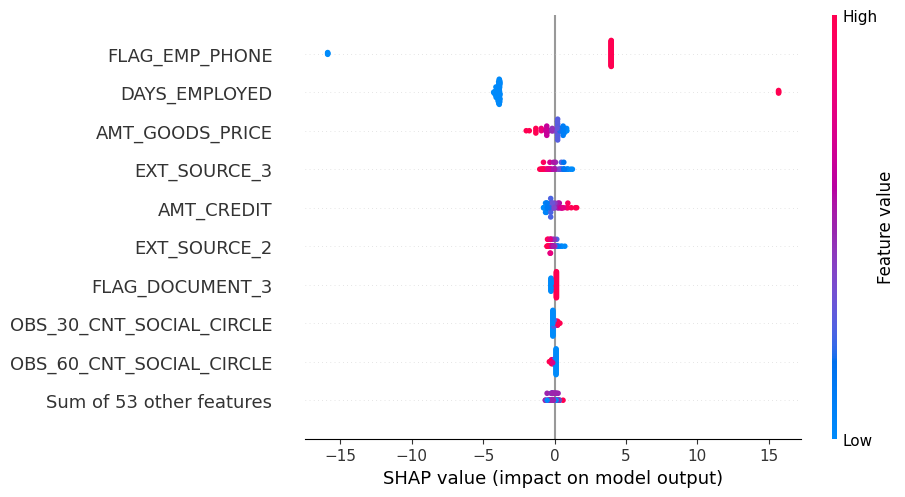

In [27]:
explain_model_shap(pipeline_lr, X_train, X_test, "Logistic Regression")



📌 SHAP summary pour Random Forest 📊


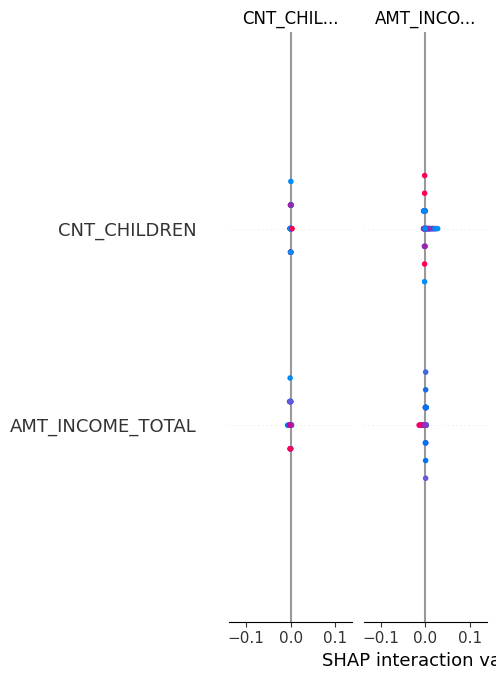

In [28]:
explain_model_shap(pipeline_rf, X_train, X_test, "Random Forest")


📌 SHAP summary pour XGBoost 📊


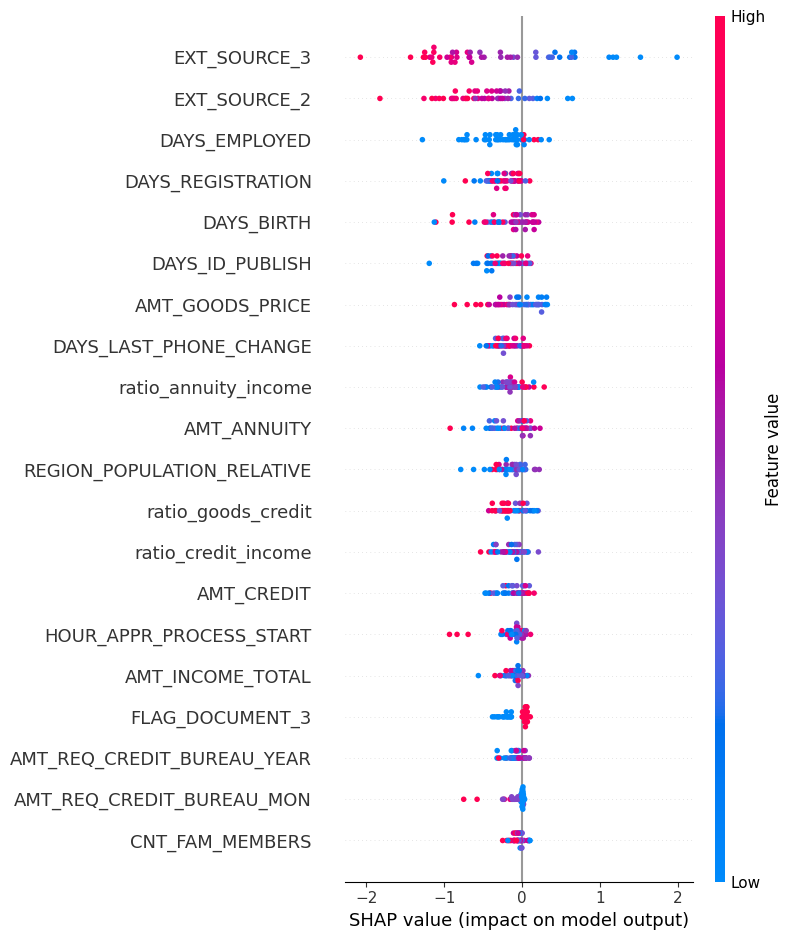

In [29]:
explain_model_shap(pipeline_xgb, X_train, X_test, "XGBoost")

In [51]:
#script pour alléger le dataset application_train.csv 
import pandas as pd
import os

# Charger le dataset complet
df = pd.read_csv("data/application_train.csv")

# Créer les colonnes utiles pour le conseiller
df_subset = pd.DataFrame()
df_subset["SK_ID_CURR"] = df["SK_ID_CURR"]
df_subset["age"] = (-df["DAYS_BIRTH"] / 365).round(1)
df_subset["revenu"] = df["AMT_INCOME_TOTAL"]
df_subset["anciennete"] = (-df["DAYS_EMPLOYED"] / 365).replace({365243/365: 0}).round(1)
df_subset["nb_incidents"] = df["DEF_30_CNT_SOCIAL_CIRCLE"].fillna(0) + df["DEF_60_CNT_SOCIAL_CIRCLE"].fillna(0)
df_subset["score_credit"] = None  # à remplir après entraînement

# Vérifier les 5 premières lignes
print(df_subset.head())

# Sauvegarder dans le même dossier que le notebook
output_path = os.path.join(os.getcwd(), "dataset_conseiller.csv")
df_subset.to_csv(output_path, index=False)

# Confirmation
print(f"\n Fichier enregistré avec succès : {output_path}")

   SK_ID_CURR   age    revenu  anciennete  nb_incidents score_credit
0      100002  25.9  202500.0         1.7           4.0         None
1      100003  45.9  270000.0         3.3           0.0         None
2      100004  52.2   67500.0         0.6           0.0         None
3      100006  52.1  135000.0         8.3           0.0         None
4      100007  54.6  121500.0         8.3           0.0         None

 Fichier enregistré avec succès : /Users/mariam/Desktop/ISCOD_support_cours 2/bloc 4/étude de cas/Rendu/dataset_conseiller.csv


In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import joblib

# Chargement
df = pd.read_csv("data/application_train.csv")
df = df[df["DAYS_EMPLOYED"] != 365243]

# Features simples
df["revenu"] = df["AMT_INCOME_TOTAL"]
df["age"] = (-df["DAYS_BIRTH"] / 365).round(1)
df["anciennete"] = (-df["DAYS_EMPLOYED"] / 365).round(1)
df["nb_incidents"] = df["DEF_30_CNT_SOCIAL_CIRCLE"].fillna(0) + df["DEF_60_CNT_SOCIAL_CIRCLE"].fillna(0)

features = ["revenu", "age", "anciennete", "nb_incidents"]
X = df[features]
y = df["TARGET"]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Pipeline
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier(random_state=42))
])

pipeline.fit(X_train, y_train)

# Sauvegarde
joblib.dump(pipeline, "model/pipeline_simple.pkl")
print("✅ Modèle entraîné et sauvegardé.")


✅ Modèle entraîné et sauvegardé.


In [50]:

# Charger les données brutes
df = pd.read_csv("data/application_train.csv")

# Nettoyage
df = df[df["DAYS_EMPLOYED"] != 365243]
df = df.dropna(subset=["AMT_INCOME_TOTAL", "DAYS_BIRTH", "DAYS_EMPLOYED", "DEF_30_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE"])

# Feature engineering simple (correspondant à ce que le modèle utilise)
df_subset = pd.DataFrame()
df_subset["SK_ID_CURR"] = df["SK_ID_CURR"]
df_subset["age"] = (-df["DAYS_BIRTH"] / 365).round(1)
df_subset["revenu"] = df["AMT_INCOME_TOTAL"]
df_subset["anciennete"] = (-df["DAYS_EMPLOYED"] / 365).round(1)
df_subset["nb_incidents"] = df["DEF_30_CNT_SOCIAL_CIRCLE"].fillna(0) + df["DEF_60_CNT_SOCIAL_CIRCLE"].fillna(0)

# Charger le modèle pipeline (avec scaler + XGB)
pipeline = joblib.load("model/pipeline_simple.pkl")

# Prédire les scores
features_model = ["revenu", "age", "anciennete", "nb_incidents"]
df_subset["score_credit"] = pipeline.predict_proba(df_subset[features_model])[:, 1]

# Sauvegarder
df_subset.to_csv("dataset_conseiller.csv", index=False)
print("✅ Dataset conseiller simple généré avec succès.")


✅ Dataset conseiller simple généré avec succès.


In [52]:
print("✅ Colonnes de X_clean :")
print(list(X_clean.columns))

print("\n✅ Colonnes attendues par le pipeline :")
print(list(pipeline_xgb.feature_names_in_))


✅ Colonnes de X_clean :
['revenu', 'age', 'anciennete', 'nb_incidents', 'revenu_par_age', 'anciennete_par_age', 'revenu_par_anciennete']

✅ Colonnes attendues par le pipeline :
['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'F

In [40]:
print(pipeline_xgb.named_steps)


{'scaler': StandardScaler(), 'xgb': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, ...)}


In [89]:
import joblib

# Sauvegarder le pipeline entraîné
joblib.dump(pipeline_xgb, "model/pipeline_xgb.pkl")
print("✅ Modèle sauvegardé sous model/pipeline_xgb.pkl")


✅ Modèle sauvegardé sous model/pipeline_xgb.pkl


In [92]:
import joblib
model = joblib.load("model/pipeline_simple.pkl")
print(model)


Pipeline(steps=[('scaler', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                        

In [ ]:
#Rééquilibrer les classes avec scale_pos_weight
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import joblib

# Charger les données brutes
df = pd.read_csv("data/application_train.csv")

# Nettoyage de base
df = df[df["DAYS_EMPLOYED"] != 365243]
df = df.dropna(subset=[
    "AMT_INCOME_TOTAL", "DAYS_BIRTH", "DAYS_EMPLOYED",
    "DEF_30_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE", "TARGET"
])

# 🧪 Création des variables
df["revenu"] = df["AMT_INCOME_TOTAL"]
df["age"] = (-df["DAYS_BIRTH"] / 365).round(1)
df["anciennete"] = (-df["DAYS_EMPLOYED"] / 365).round(1)
df["nb_incidents"] = df["DEF_30_CNT_SOCIAL_CIRCLE"].fillna(0) + df["DEF_60_CNT_SOCIAL_CIRCLE"].fillna(0)

# Définir les features et la cible
features = ["revenu", "age", "anciennete", "nb_incidents"]
X = df[features]
y = df["TARGET"]

# Calcul du poids pour rééquilibrer les classes
pos_weight = (y == 0).sum() / (y == 1).sum()

# Création du pipeline
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        scale_pos_weight=pos_weight,
        use_label_encoder=False,
        eval_metric="logloss"
    ))
])

# Entraînement du modèle
pipeline.fit(X, y)

# Sauvegarde du modèle
joblib.dump(pipeline, "model/pipeline_simple.pkl")
print("✅ Nouveau modèle entraîné et sauvegardé : pipeline_simple.pkl")


✅ Nouveau modèle entraîné et sauvegardé : pipeline_simple.pkl
